# Threshold Evaluation for multiple sampling values

This stage evaluates the results with the detector, comparing them with the original spiketrains. To do this, it requires to load the NEO files for each value of resolution.

## Loading NEO files 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_DIR="/mnt/Archivos/data"

In [3]:
from eapprocessor.tools.load import load_neo, load_count_evaluation, get_evaluation_files

In [4]:
noise_levels = [5, 25]
resolutions = [10,9,8,7,6,5,4,3]
fs=20000

In [5]:
neo_list=[]
neo_files=[]
for resolution in resolutions:
    neo_list_resolution = []
    neo_files_resolution =[]
    for noise_level in noise_levels:
        neo_dict, file = load_neo(f"{BASE_DIR}/output/preprocessor", verbose=True, resolution=resolution, 
                           noise_level=noise_level, fs=fs)
        neo_list_resolution += [neo_dict]
        neo_files_resolution += [file]
    
    neo_list += [neo_list_resolution]
    neo_files += [neo_files_resolution]

Search for pattern: *_10_5uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_5uV_20000Hz_2021-11-04_16-18.h5
Search for pattern: *_10_25uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_25uV_20000Hz_2021-11-04_16-18.h5
Search for pattern: *_9_5uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_9_5uV_20000Hz_2021-11-04_16-18.h5
Search for pattern: *_9_25uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_9_25uV_20000Hz_2021-11-04_16-18.h5
Search for pattern: *_8_5uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_8_5uV_20000Hz_2021-11-04_16-19.h5
Search for pattern: *_8_25uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_8_25uV_20000Hz_2021-11-04_16-19.h5
Search for pattern: *_7_5uV_20000Hz*
Loading file /mnt/Archivos/data/output/preprocessor/preprocessed_neo_7_5uV_20000Hz_2021-11-04_16-19.h5
Search for

## Exploring converted signals

In [13]:
from eapprocessor.plot.signals import plot_transient_converted, plot_transient_recordings, plot_transient_neo

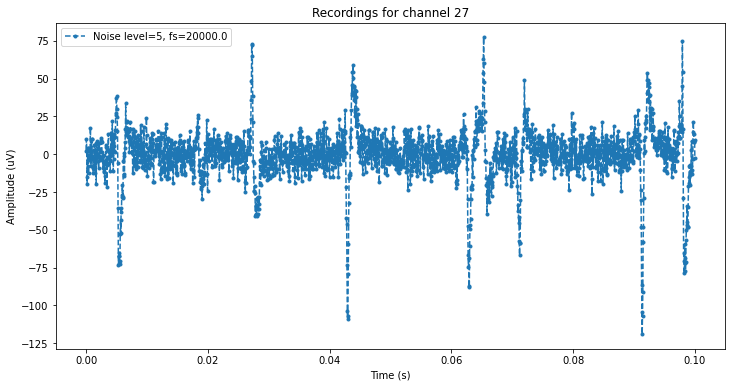

In [12]:
plot_transient_recordings(neo_list[0][0]["recordings"], channels=[27], t_stop=0.1,marker='.--')

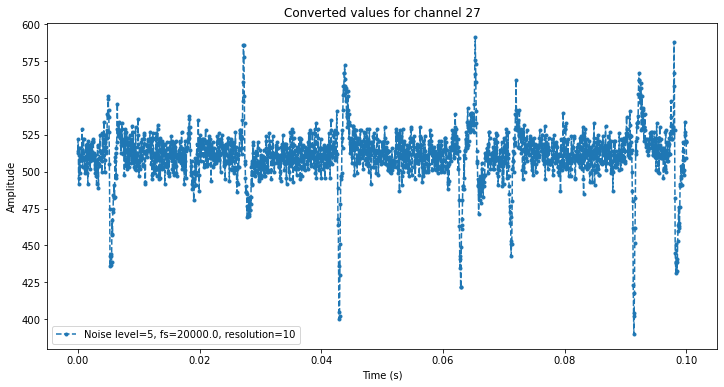

In [8]:
plot_transient_converted(neo_list[0][0], channels=[27], t_stop=0.1,marker='.--')

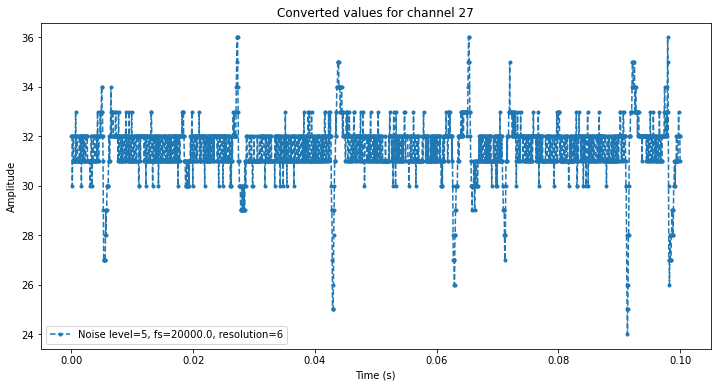

In [9]:
plot_transient_converted(neo_list[4][0], channels=[27], t_stop=0.1,marker='.--')

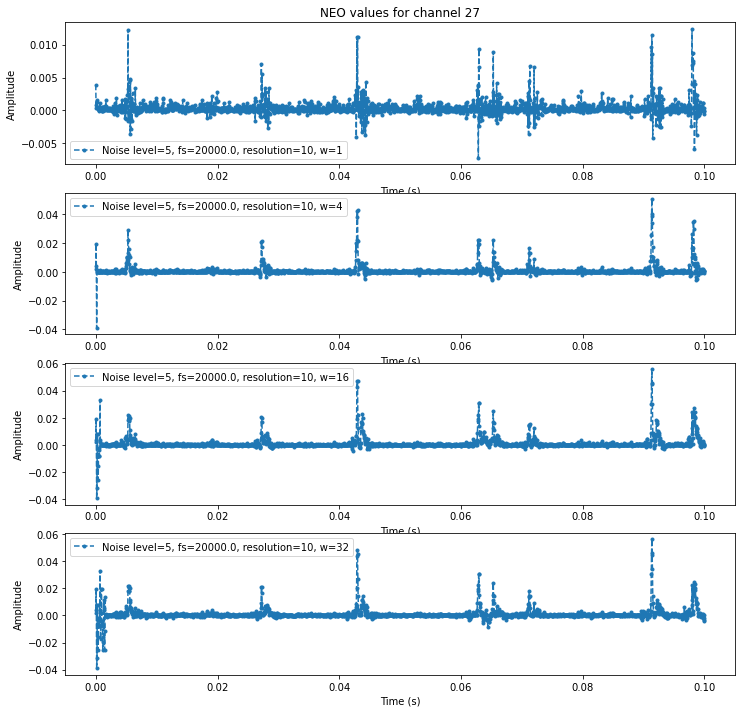

In [19]:
plot_transient_neo(neo_list[0][0], channels=[27], t_stop=0.1,marker='.--')

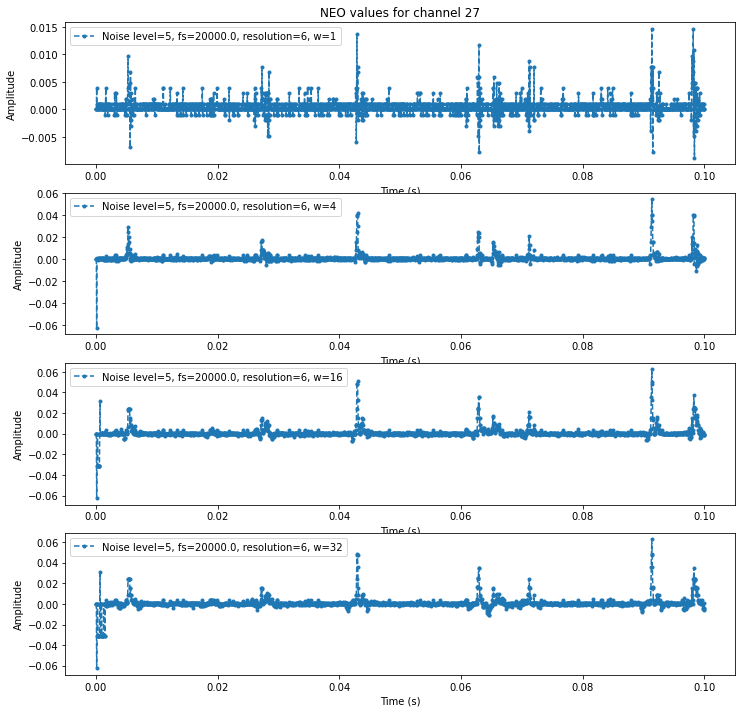

In [20]:
plot_transient_neo(neo_list[4][0], channels=[27], t_stop=0.1,marker='.--')

## Getting evaluation files

In [6]:
evaluator_files_dict_list = []
for neo_files_resolution in neo_files:
    evaluator_files_dict_list_resolution=[]
    for neo_file in neo_files_resolution: 
        file_dict = get_evaluation_files(f"{BASE_DIR}/output/evaluator",sourcefile=neo_file) 
        evaluator_files_dict_list_resolution += [file_dict]
    evaluator_files_dict_list += [evaluator_files_dict_list_resolution]

Search for pattern: *
Filename found 3 files with source /mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_5uV_20000Hz_2021-11-04_16-18.h5
[PosixPath('/mnt/Archivos/data/output/evaluator/threshold_recordings_subset_50th_10_5uV_20000Hz_2021-11-04_16-27.h5'), PosixPath('/mnt/Archivos/data/output/evaluator/threshold_normalized_subset_50th_10_5uV_20000Hz_2021-11-04_16-27.h5'), PosixPath('/mnt/Archivos/data/output/evaluator/threshold_neo_subset_50th_10_5uV_20000Hz_2021-11-04_16-27.h5')]
Search for pattern: *
Filename found 3 files with source /mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_25uV_20000Hz_2021-11-04_16-18.h5
[PosixPath('/mnt/Archivos/data/output/evaluator/threshold_recordings_subset_50th_10_25uV_20000Hz_2021-11-04_16-28.h5'), PosixPath('/mnt/Archivos/data/output/evaluator/threshold_normalized_subset_50th_10_25uV_20000Hz_2021-11-04_16-28.h5'), PosixPath('/mnt/Archivos/data/output/evaluator/threshold_neo_subset_50th_10_25uV_20000Hz_2021-11-04_16-28.h5')]
Sear

## Getting indexes for spiketrains positions

In [7]:
spiketrain_obj_list = neo_list[0][0]["recordings"].spiketrains

In [8]:
import numpy as np

In [9]:
spiketrain_list = [np.array(spiketrain[:]) for spiketrain in spiketrain_obj_list]

In [10]:
timestamps = neo_list[0][0]["recordings"].timestamps[:]
print(timestamps)

[0.00000e+00 5.00000e-05 1.00000e-04 ... 9.99985e+00 9.99990e+00
 9.99995e+00]


In [11]:
from eapprocessor.evaluator.spikes import estimate_sample_spikes, comparison_detection_spiketrain

In [12]:
indexes_list = []
errors_list = []
for spiketrain in spiketrain_list:
    indexes, errors = estimate_sample_spikes(spikes=spiketrain,timestamps=timestamps)
    indexes_list += [indexes]
    errors_list += [errors]

## Evaluating for each noise level

In [21]:
from eapprocessor.process import get_results_evaluation_dataset_array
from eapprocessor.evaluator.spikes import convert_to_roc_list
from eapprocessor.plot.evaluator import plot_roc_list, plot_accuracy_list
from eapprocessor.tools.load import load_converted_values, load_neo, \
    load_count_evaluation, load_indexes, load_channels

In [17]:
def results_evaluator(evaluator_files_dict_list,
                      indexes_list,
                      spike_indexes,
                      noise_levels,
                      w,
                      window_time=None,
                      neo_files=None,
                      ):
    evaluator_files_neo = [evaluator_files_dict["neo_file"]
                           for evaluator_files_dict in evaluator_files_dict_list]
    neo_evaluation_dics = get_results_evaluation_dataset_array(evaluator_files_neo, 
                                                               indexes_list,
                                                               channel_idx=1,
                                                              window_time=window_time,
                                                              origin_files=neo_files)

    tpr_neo_list, fpr_neo_list = convert_to_roc_list(neo_evaluation_dics, 
                                                     range_reference=spike_indexes)

    print(tpr_neo_list.shape)
    
    for idx in range(len(tpr_neo_list)):
        plot_roc_list(fpr_list=fpr_neo_list[idx], tpr_list=tpr_neo_list[idx], 
                    labels=[f"w={w_i}" for w_i in w],
                    spiketrains_labels=spike_indexes,
                    append_title=f", Noise level {noise_levels[idx]}")


In [20]:
neo_files[0]

[PosixPath('/mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_5uV_20000Hz_2021-11-04_16-18.h5'),
 PosixPath('/mnt/Archivos/data/output/preprocessor/preprocessed_neo_10_25uV_20000Hz_2021-11-04_16-18.h5')]

In [24]:
neo_dict, _ = load_neo(filename=neo_files[0][0],
                                   is_lcadc=False)
neo_dict

{'adcinfo': {'resolution': 10, 'voltage_ref': 500},
 'adc': <HDF5 dataset "adc": shape (32, 200000), type "<i8">,
 'normalized': <HDF5 dataset "normalized": shape (32, 200000), type "<f8">,
 'recordings': <MEArec.generators.recordinggenerator.RecordingGenerator at 0x7fa5ebd78310>,
 'w': <HDF5 dataset "w": shape (4,), type "<i8">,
 'neo': <HDF5 dataset "neo": shape (4, 32, 200000), type "<f8">}

In [29]:
neo_dict["recordings"].info["recordings"]["fs"]

20000.0

(2, 4, 50, 3)


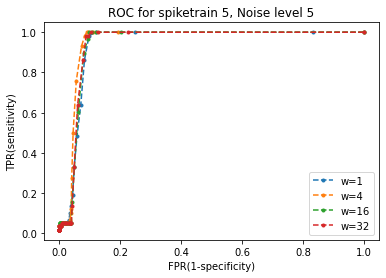

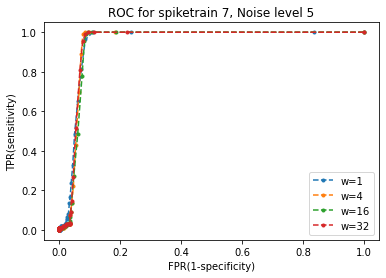

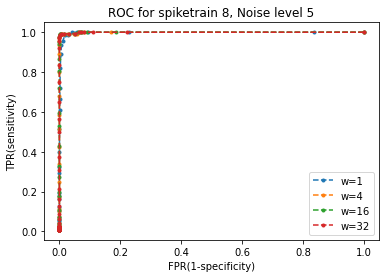

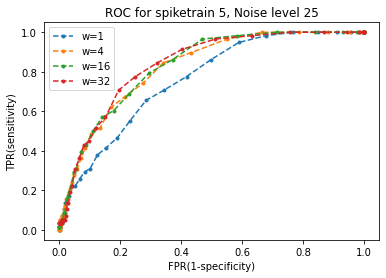

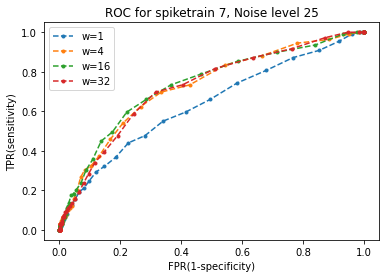

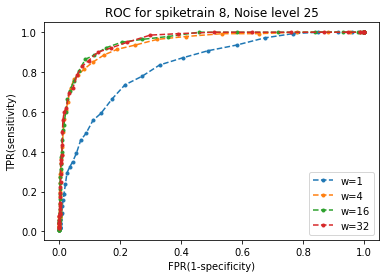

In [30]:
results_evaluator(evaluator_files_dict_list[0],
                 indexes_list,
                 [5,7,8],
                 noise_levels,
                 [1,4,16,32],
                 window_time=2.5e-3,
                 neo_files=neo_files[0])

(2, 4, 50, 3)


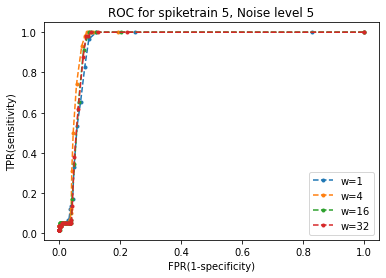

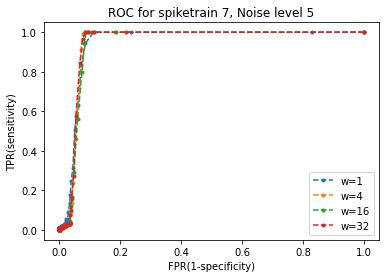

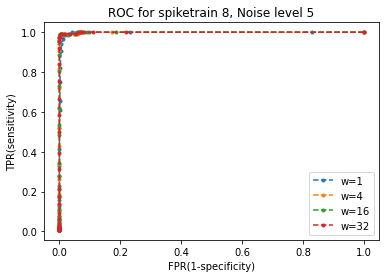

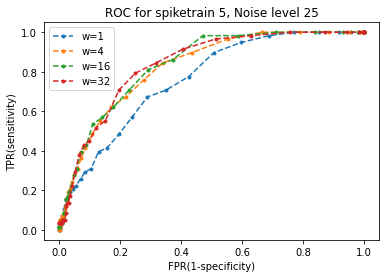

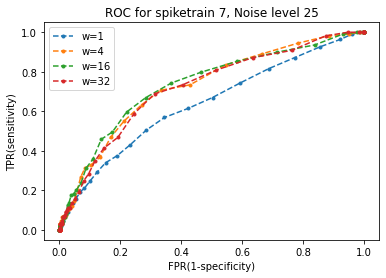

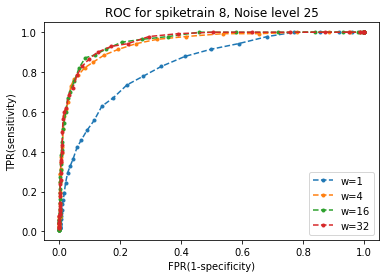

In [31]:
results_evaluator(evaluator_files_dict_list[1],
                 indexes_list,
                 [5,7,8],
                 noise_levels,
                 [1,4,16,32],
                 window_time=2.5e-3,
                 neo_files=neo_files[1])

(2, 4, 50, 3)


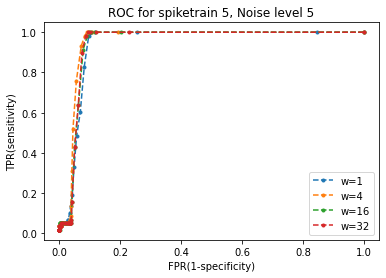

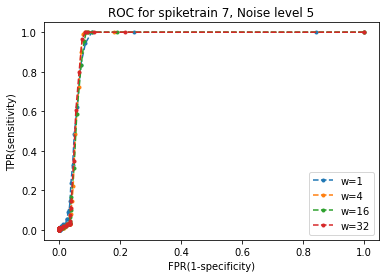

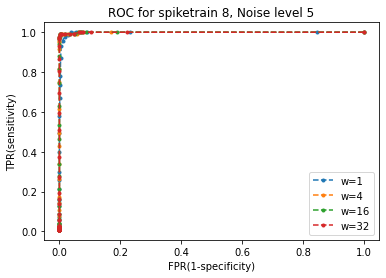

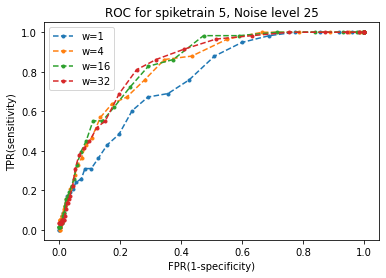

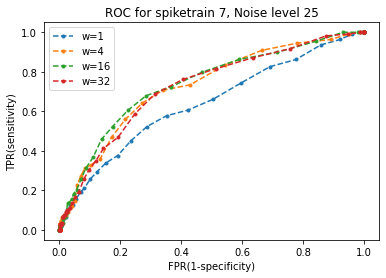

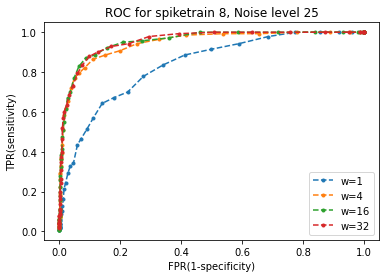

In [32]:
results_evaluator(evaluator_files_dict_list[2],
                 indexes_list,
                 [5,7,8],
                 noise_levels,
                 [1,4,16,32],
                 window_time=2.5e-3,
                 neo_files=neo_files[2])

(2, 4, 50, 3)


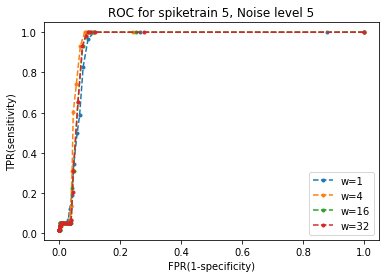

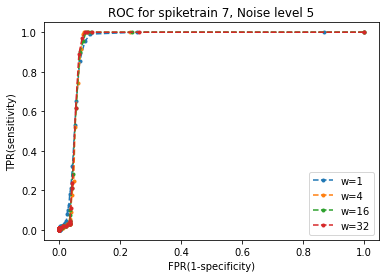

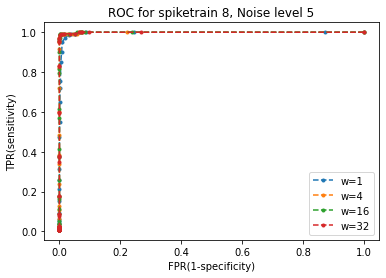

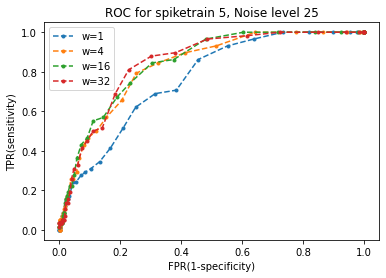

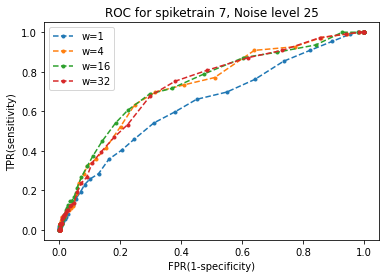

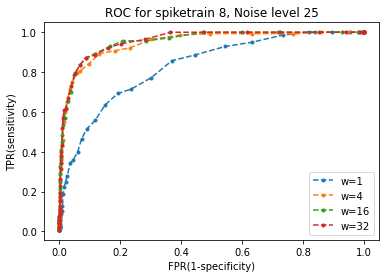

In [33]:
results_evaluator(evaluator_files_dict_list[3],
                 indexes_list,
                 [5,7,8],
                 noise_levels,
                 [1,4,16,32],
                 window_time=2.5e-3,
                 neo_files=neo_files[3])

(2, 4, 50, 3)


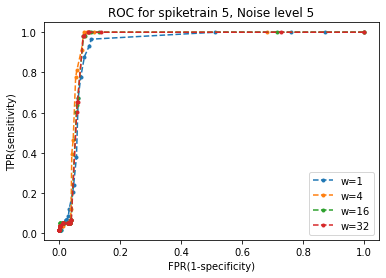

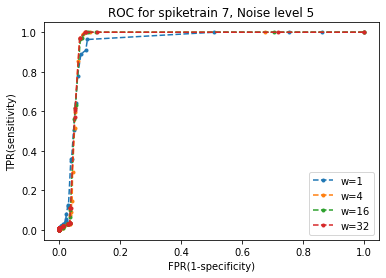

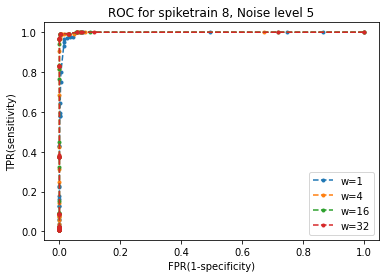

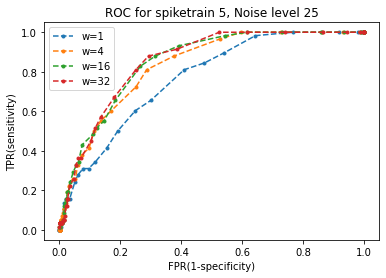

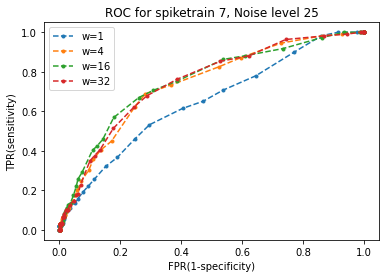

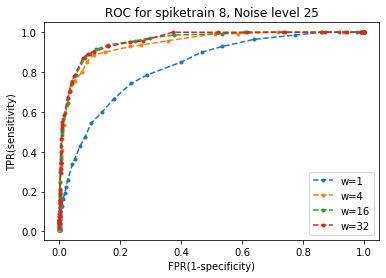

In [34]:
results_evaluator(evaluator_files_dict_list[4],
                 indexes_list,
                 [5,7,8],
                 noise_levels,
                 [1,4,16,32],
                 window_time=2.5e-3,
                 neo_files=neo_files[4])

In [35]:
from eapprocessor.evaluator.spikes import comparison_detection_array_spiketrain_array, convert_to_roc, \
    convert_to_accuracy, convert_to_accuracy_list
from eapprocessor.tools.load import load_evaluation

In [36]:
def results_recordings(evaluator_files_dict_list,
                      indexes_list,
                      spike_indexes,
                      noise_levels):
    evaluator_files_rec = [load_evaluation(evaluator_files_dict["recordings_file"])
                           for evaluator_files_dict in evaluator_files_dict_list]
    
    comparison_recordings_list = [comparison_detection_array_spiketrain_array(indexes_list, dic["indexes"][1],50) 
                             for dic in evaluator_files_rec]

    tpr_rec_list = []
    fpr_rec_list = []
    for comparison_rec in comparison_recordings_list:
        tpr_rec, fpr_rec = convert_to_roc(comparison_rec, range_reference=spike_indexes)
        tpr_rec_list +=[tpr_rec]
        fpr_rec_list +=[fpr_rec]
    
    plot_roc_list(fpr_list=fpr_rec_list, tpr_list=tpr_rec_list, 
                labels=[f"noise={noise_level}" for noise_level in noise_levels],
                spiketrains_labels=spike_indexes)

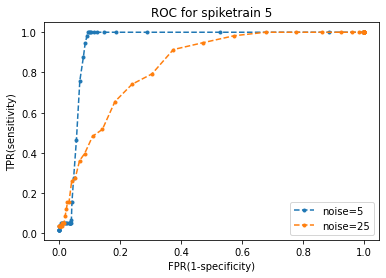

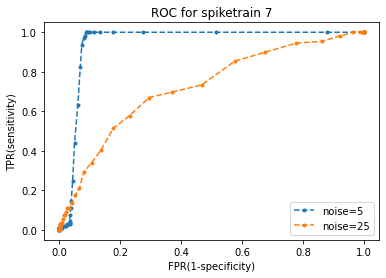

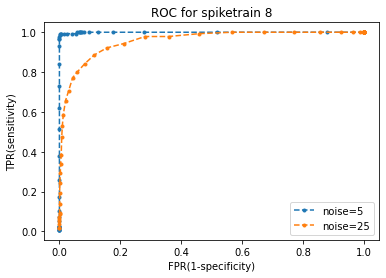

In [37]:
results_recordings(evaluator_files_dict_list[0],
                 indexes_list,
                 [5,7,8],
                 noise_levels)

In [38]:
def results_converted(evaluator_files_dict_list,
                      indexes_list,
                      spike_indexes,
                      noise_levels):
    evaluator_files_rec = [load_evaluation(evaluator_files_dict["normalized_file"])
                           for evaluator_files_dict in evaluator_files_dict_list]
    
    comparison_recordings_list = [comparison_detection_array_spiketrain_array(indexes_list, dic["indexes"][1],50) 
                             for dic in evaluator_files_rec]

    tpr_rec_list = []
    fpr_rec_list = []
    for comparison_rec in comparison_recordings_list:
        tpr_rec, fpr_rec = convert_to_roc(comparison_rec, range_reference=spike_indexes)
        tpr_rec_list +=[tpr_rec]
        fpr_rec_list +=[fpr_rec]
    
    plot_roc_list(fpr_list=fpr_rec_list, tpr_list=tpr_rec_list, 
                labels=[f"noise={noise_level}" for noise_level in noise_levels],
                spiketrains_labels=spike_indexes)

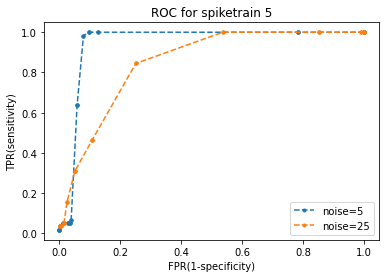

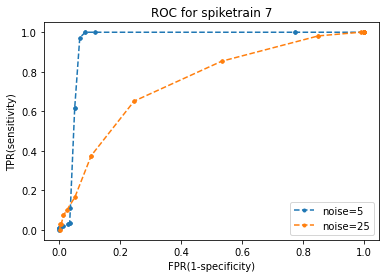

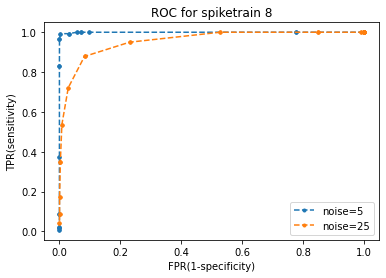

In [39]:
results_converted(evaluator_files_dict_list[4],
                 indexes_list,
                 [5,7,8],
                 noise_levels)

In [40]:
def results_acuracy_converted(evaluator_files_dict_list,
                      indexes_list,
                      spike_indexes,
                      labels):
    evaluator_files_rec = [load_evaluation(evaluator_files_dict["normalized_file"])
                           for evaluator_files_dict in evaluator_files_dict_list]
    
    comparison_recordings_list = [comparison_detection_array_spiketrain_array(indexes_list, dic["indexes"][1],50) 
                             for dic in evaluator_files_rec]

    accuracy_list = convert_to_accuracy_list(comparison_recordings_list, range_reference=spike_indexes)

    
    plot_accuracy_list(accuracy_list=accuracy_list, 
                labels=labels,
                spiketrains_labels=spike_indexes)
    
    return accuracy_list

array([[[0.01451815, 0.02725681, 0.03501751],
        [0.01451815, 0.02725681, 0.03501751],
        [0.01451815, 0.02725681, 0.03501751],
        [0.01456554, 0.02730461, 0.03510532],
        [0.01647727, 0.03112507, 0.03989741],
        [0.02617329, 0.04959054, 0.06292135],
        [0.05101143, 0.09637489, 0.12048193],
        [0.07379135, 0.13832487, 0.17456359],
        [0.09105181, 0.17219589, 0.22292994],
        [0.10800745, 0.2       , 0.2745098 ],
        [0.11530815, 0.21456693, 0.30634573],
        [0.12314225, 0.22755741, 0.3271028 ],
        [0.1277533 , 0.23747277, 0.3406326 ],
        [0.13063063, 0.24222222, 0.34482759],
        [0.13647059, 0.24654378, 0.35353535],
        [0.13701923, 0.25178147, 0.35989717],
        [0.14213198, 0.25879397, 0.37634409],
        [0.13934426, 0.24064171, 0.40524781],
        [0.13707165, 0.2111437 , 0.46644295],
        [0.10600707, 0.17320261, 0.56504065],
        [0.07053942, 0.09677419, 0.71649485],
        [0.04072398, 0.0651341 , 0

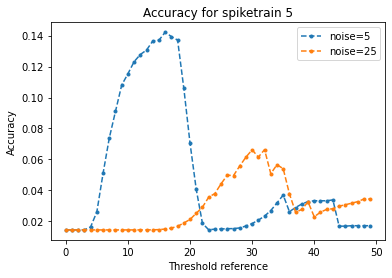

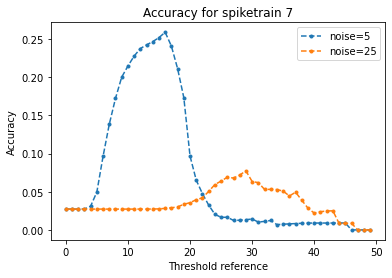

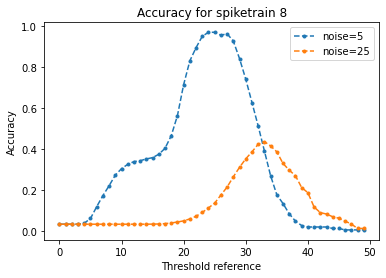

In [41]:
results_acuracy_converted(evaluator_files_dict_list[0],
                 indexes_list,
                 [5,7,8],
                 [f"noise={noise_level}" for noise_level in noise_levels])

array([[[0.01451815, 0.02725681, 0.03501751],
        [0.01451815, 0.02725681, 0.03501751],
        [0.01451815, 0.02725681, 0.03501751],
        [0.01451815, 0.02725681, 0.03501751],
        [0.01847134, 0.03486884, 0.04458599],
        [0.01847134, 0.03486884, 0.04458599],
        [0.01847134, 0.03486884, 0.04458599],
        [0.01847134, 0.03486884, 0.04458599],
        [0.10357143, 0.19360568, 0.2739726 ],
        [0.10357143, 0.19360568, 0.2739726 ],
        [0.10357143, 0.19360568, 0.2739726 ],
        [0.13333333, 0.24716553, 0.33980583],
        [0.13333333, 0.24716553, 0.33980583],
        [0.13333333, 0.24716553, 0.33980583],
        [0.13333333, 0.24716553, 0.33980583],
        [0.15447154, 0.28648649, 0.38781163],
        [0.15447154, 0.28648649, 0.38781163],
        [0.15447154, 0.28648649, 0.38781163],
        [0.12891986, 0.21967213, 0.53875969],
        [0.12891986, 0.21967213, 0.53875969],
        [0.12891986, 0.21967213, 0.53875969],
        [0.12891986, 0.21967213, 0

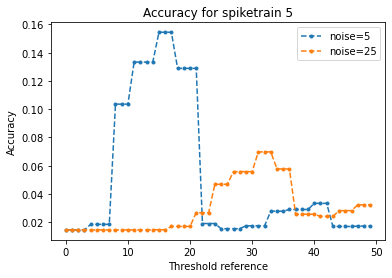

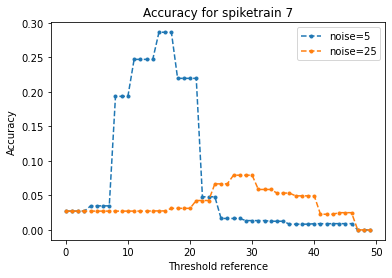

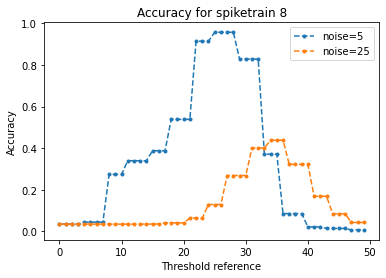

In [42]:
results_acuracy_converted(evaluator_files_dict_list[4],
                 indexes_list,
                 [5,7,8],
                 [f"noise={noise_level}" for noise_level in noise_levels])

In [43]:
evaluator_files_5uv_list= [evaluator_files[0] for evaluator_files in  evaluator_files_dict_list]
evaluator_files_25uv_list= [evaluator_files[1] for evaluator_files in  evaluator_files_dict_list]

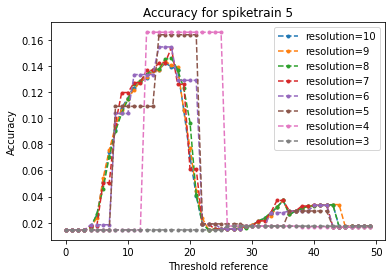

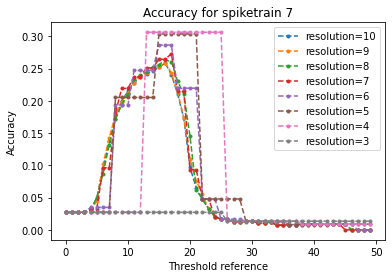

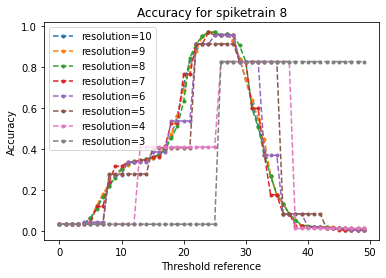

In [44]:
results_5uv=results_acuracy_converted(evaluator_files_5uv_list,
                 indexes_list,
                 [5,7,8],
                 [f"resolution={resolution}" for resolution in resolutions])

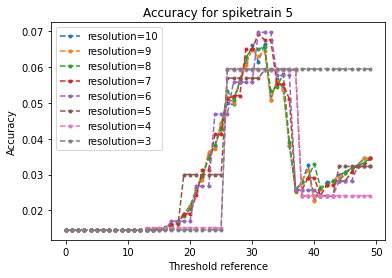

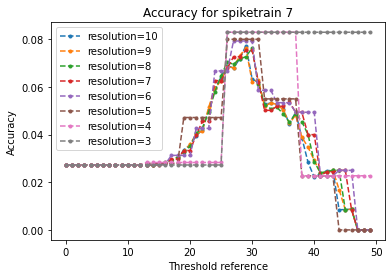

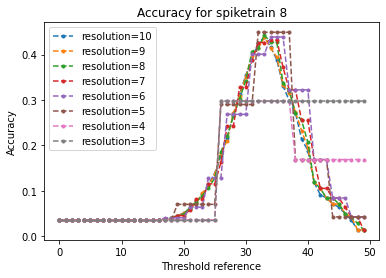

In [45]:
results_25uv=results_acuracy_converted(evaluator_files_25uv_list,
                 indexes_list,
                 [5,7,8],
                 [f"resolution={resolution}" for resolution in resolutions])

In [46]:
results_5uv_t = np.transpose(results_5uv, (2, 0, 1))
results_5uv_t.shape

(3, 8, 50)

In [47]:
results_25uv_t = np.transpose(results_25uv, (2, 0, 1))
results_25uv_t.shape

(3, 8, 50)

In [48]:
import matplotlib.pyplot as plt

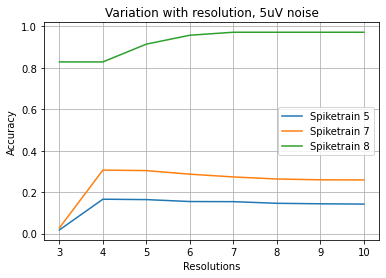

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for idx,spiketrain in enumerate([5,7,8]):
    vector = results_5uv_t[idx].max(axis=1)
    ax.plot(resolutions,vector,label=f"Spiketrain {spiketrain}")
    ax.set_xlabel("Resolutions")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="best")
    ax.set_title("Variation with resolution, 5uV noise")
    ax.grid(True)

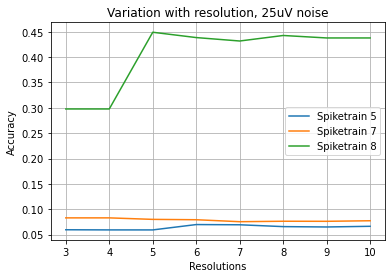

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for idx,spiketrain in enumerate([5,7,8]):
    vector = results_25uv_t[idx].max(axis=1)
    plt.plot(resolutions,vector,label=f"Spiketrain {spiketrain}")
    ax.set_xlabel("Resolutions")
    ax.set_ylabel("Accuracy")
    ax.legend(loc="best")
    ax.set_title("Variation with resolution, 25uV noise")
    ax.grid(True)